# Iterative *Bayesian Model Reduction*, for FCNs using VBP inference

This notebook provides a demo for our proposed iterative BMR procedure, where we alternate training and compression. It is implemented for BNNs using an FCN model and VBP inference.

## GPU support

This block is to disable GPU execution of TensorFlow. Depending on your system, enabling GPU may result in faster training.

*Comment this block to enable GPU execution*

In [1]:
# Disable GPU execution
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Packages

We import some standard packages as wel as TensorFlow and our own Bayesian TensorFlow package, make sure you have them installed prior!

In [2]:
# Import packages
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import bayesian_tensorflow as btf

## Setup

Below we set the experiment details for the demo, mostly concerning the specific dataset and the number of training epochs.

We use a seed for reproducibility, but this can be ignored if preferred by setting it to `None`.

In [3]:
# Set hyperparameters
name     = 'boston'
n_epochs =  750
seed     =  60

Based on the dataset we set the batch-size, which we do below.

In [4]:
# Get proper batch-size
if name in ['boston', 'energy', 'yacht']: 
    batch_size = 16
elif name in ['concrete', 'wine']: 
    batch_size = 32
else: # i.e. [kin8nm, naval, powerplant]
    batch_size = 64

Finally, we set the number of epochs used for retraining after pruning.

In [5]:
# Re-train epochs
prun_epochs = 150

## Dataset

We have inlcuded the UCI datasets used in our paper, which we have stored in the `dataset` folder.

You can load a specific dataset using the function `uci.load` and specifying the name of the dataset.

In [6]:
# Get custom datasets module
from datasets import uci

# Load dataset
(x, y) = uci.load(name=name, seed=seed)

We save the total number of data samples, as this is needed in the computation of the VFE loss.

In [7]:
# Total data size
n_data = tf.cast(tf.shape(x)[0], dtype=tf.float32)

We then set our seed for randomness, combine the data samples into a TensorFlow dataset and shuffle it.

In [8]:
# Set randomness seed
tf.random.set_seed(seed)

# Create TF-dataset
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=len(x)).batch(batch_size)

## Model

We start with a normalization layer to normalize the input data.

In [9]:
# Normalizer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(x))

Depending on the dataset, we have either one or two output nodes.

In [10]:
# Output layer units, to update with datasets
O = 2 if (name == 'energy' or name == 'naval') else 1

We now create the model using the `Sequential` model from TensorFlow, with our custom layers.

We need to specify which layer is the input layer in order to generate the input variance in that layer, we do this with the `is_input` flag.

We also need to indicate which layer is the output layer, since by default the VBP layer uses a ReLU activation. This is done with the `is_output` flag.

In [11]:
# Create model
model = tf.keras.models.Sequential([
    normalizer,
    btf.layers.DenseVBP(50, is_input=True, seed=seed),
    btf.layers.DenseVBP(O, is_output=True, seed=seed),
    btf.layers.GammaVBP(O),
])

__*You always need to add a Gamma layer to the end of the model!*__

This layers adds the gamma parameters into the model and allows for joint optimization.

In [12]:
# Overview of model
model.summary(line_length=75, positions=[0.55, 0.85, 1.0, 1.0])

Model: "sequential"
___________________________________________________________________________
 Layer (type)                            Output Shape          Param #     
 normalization (Normalization)           (None, 13)            27          
                                                                           
 dense_vbp (DenseVBP)                    (None, 50, 2)         1400        
                                                                           
 dense_vbp_1 (DenseVBP)                  (None, 1, 2)          102         
                                                                           
 gamma_vbp (GammaVBP)                    (None, 1, 4)          2           
                                                                           
Total params: 1,531
Trainable params: 1,504
Non-trainable params: 27
___________________________________________________________________________


## Initial Training

We save the three separate terms of the VFE loss for evaluation of the training process.

In [13]:
# Variables to store training results
vfe_kl_theta = np.zeros(n_epochs)
vfe_kl_tau   = np.zeros(n_epochs)
vfe_acc_loss = np.zeros(n_epochs)

We use the `Adam` optimizer for the training and set the learning rate accordingly.

In [14]:
# Set correct learning rate
lr = 1e-3 if (name in ['naval']) else 1e-2

# Create optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

We use a custom training loop with progress bar to overview the training process.

The custom update step is included in `btf.inference.BBB`, which performs VFE minimization on mini-batches.

It also returns the three separate terms of the VFE loss.

In [15]:
# Custom training loop
for epoch in tqdm(range(n_epochs), desc='Training'):    
    
    # Iterate over training batches
    for x_batch, y_batch in dataset:
        
        # Perform training step
        kl_theta, kl_tau, acc_loss = \
            btf.inference.VBP(model, optim, x_batch, y_batch, n_data)
            
        # Add losses to total
        vfe_kl_theta[epoch] += kl_theta
        vfe_kl_tau[epoch]   += kl_tau
        vfe_acc_loss[epoch] += acc_loss

Training:   0%|          | 0/750 [00:00<?, ?it/s]

## Iterative pruning and training

After training the model once regularly, we get to the iterative procedure.

We use separate functions to compress the model parameters and to reset them after the gradient update.

In [16]:
# Function to compress model
def compress_model():
    
    # Compress first dense layer
    model.layers[1].compress()
    # Compress second dense layer
    model.layers[2].compress()

In [17]:
# Function to reset model parameters
def reset_params():
    
    # Reset first dense layer
    model.layers[1].param_reset()
    # Reset second dense layer
    model.layers[2].param_reset()

We also use a function to compute the pruning rate, in order to stop to procedure when no improvements are being made.

In [18]:
# Function to compute pruning rate
def get_pruning_rate():
    
    # Get sum of masks
    S  = tf.math.reduce_sum(model.layers[1].kernel_mask)
    S += tf.math.reduce_sum(model.layers[1].bias_mask)
    S += tf.math.reduce_sum(model.layers[2].kernel_mask)
    S += tf.math.reduce_sum(model.layers[2].bias_mask)
    
    # Get total number of parameters
    N  = tf.size(model.layers[1].kernel_mask)
    N += tf.size(model.layers[1].bias_mask)
    N += tf.size(model.layers[2].kernel_mask)
    N += tf.size(model.layers[2].bias_mask)
    
    # Return pruning rate
    return 1 - int(S)/N

We use a default of 100 pruning iteration, but stop earlier if no more model parameters were pruned in a single iteration.

In [19]:
# Custom pruning loop
for epoch in tqdm(range(100*prun_epochs), desc='Pruning'):

    # Prune model if needed
    if (epoch % prun_epochs) == 0:
        
        # Check current pruning rate
        frac_prev = get_pruning_rate()
        # Compress model
        compress_model()
        # Check new pruning rate
        frac_new = get_pruning_rate()
        
        # Break if no improvement in pruning
        if frac_prev == frac_new:
            break
            
        # Print pruning info
        print('Previous pruning rate: ' + f'{frac_prev*100:2.2f}'.zfill(5) 
               + '% --> New: ' + f'{frac_new*100:2.2f}'.zfill(5) + '%')
            
    
    # Reset epoch losses
    kl_theta_epoch = 0
    kl_tau_epoch   = 0
    acc_loss_epoch = 0
    
    
    # Iterate over training batches
    for x_batch, y_batch in dataset:
        
        # Perform training step
        kl_theta, kl_tau, acc_loss = \
            btf.inference.VBP(model, optim, x_batch, y_batch, n_data)
            
        # Save batch losses
        kl_theta_epoch += kl_theta.numpy()
        kl_tau_epoch   += kl_tau.numpy()
        acc_loss_epoch += acc_loss.numpy()
        
        # Reset pruned weights
        reset_params()
        
    
    # Add losses to total
    vfe_kl_theta = np.append(vfe_kl_theta, kl_theta_epoch)
    vfe_kl_tau   = np.append(vfe_kl_tau, kl_tau_epoch)
    vfe_acc_loss = np.append(vfe_acc_loss, acc_loss_epoch)

Pruning:   0%|          | 0/15000 [00:00<?, ?it/s]

Previous pruning rate: 00.00% --> New: 88.02%
Previous pruning rate: 88.02% --> New: 94.41%


## Evaluation

We can evaluate the VFE after the iterative procedure.

In order the have reproducible results, we reset the dataset.

In [20]:
# Reset dataset without shuffling
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.batch(batch_size)

We now evaluate the model for the whole dataset.

In [21]:
# Variables to store result
vfe_total = 0
    
# Iterate over data batches
for x_batch, y_batch in dataset:

    # Get VFE loss
    vfe_total += btf.evaluation.VBP(model, x_batch, y_batch, n_data)
    
# Show final Variational Free Energy
print('Free Energy: ' + f'{vfe_total:.0f}')

Free Energy: 1455


## Plots

Finally, we can plot the total VFE loss and its separate terms for the training duration.

This function is placed into a seperate folder of `figures`.

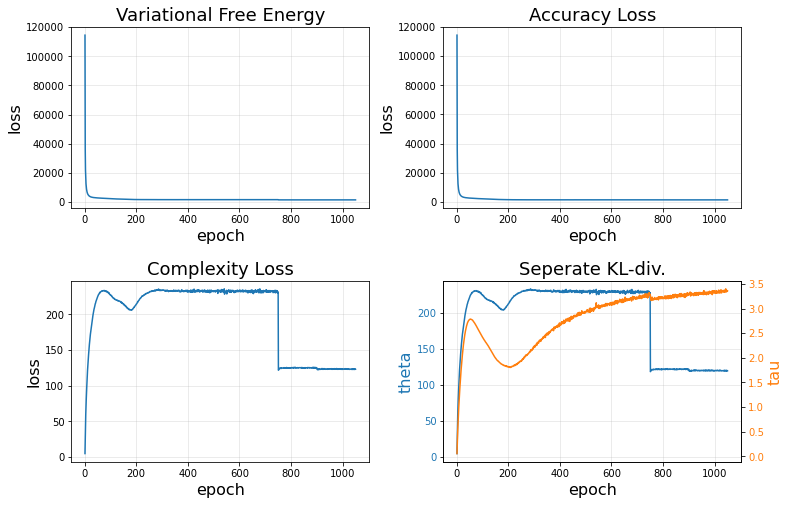

In [22]:
# Import local module
from figures import PlotTrainingLosses

# Plot training losses
PlotTrainingLosses(vfe_kl_theta, vfe_kl_tau, vfe_acc_loss)